<a href="https://colab.research.google.com/github/MounicaSrinivasan163/Brain-Tumour-MRI_Image_Classification-Using_Tensorflow/blob/main/Brain_Tumor_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras import layers, models, optimizers


# Understand the dataset

## Load the dataset

In [3]:
# -----------------------------
# 1️⃣ Parameters
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/Brain_Tumour_MRI_Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 10
NUM_CLASSES = 4

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "valid")
test_dir  = os.path.join(DATA_DIR, "test")

# -----------------------------
# 2️⃣ Load datasets
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int", seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int", seed=SEED
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int", seed=SEED
)

# Extract class names
class_names = train_ds.class_names
print("Classes:", class_names)

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


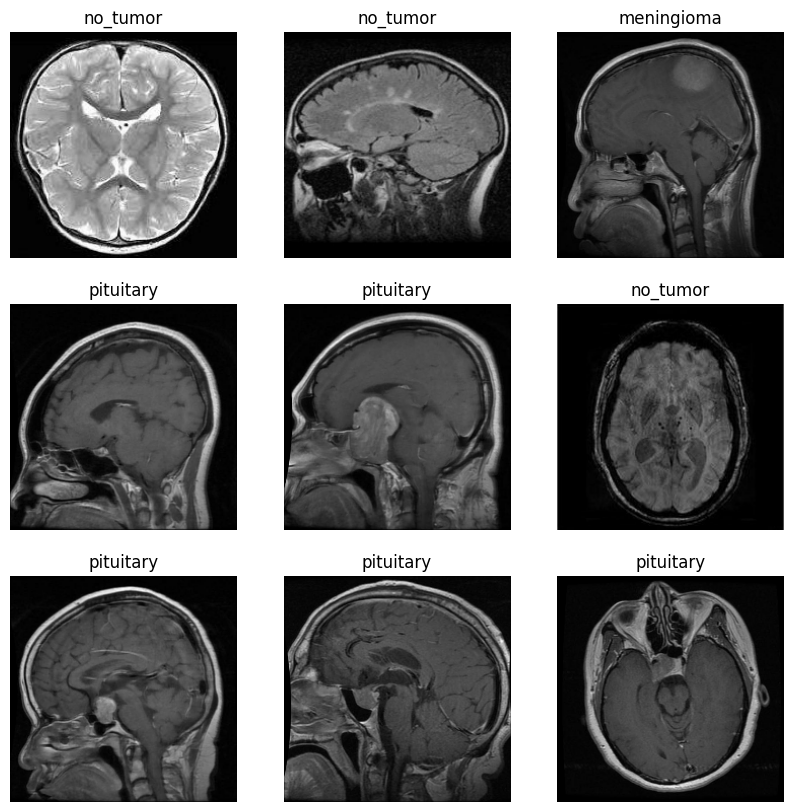

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


##Explore distributions visually

In [24]:
#Explore image distributions visually.

import numpy as np

def get_class_distribution(dataset, class_names):
    counts = {name: 0 for name in class_names}
    for _, labels in dataset.unbatch():
        counts[class_names[labels.numpy()]] += 1
    return counts

train_counts = get_class_distribution(train_ds, class_names)
val_counts   = get_class_distribution(val_ds, class_names)
test_counts  = get_class_distribution(test_ds, class_names)

print("Train distribution:", train_counts)
print("Validation distribution:", val_counts)
print("Test distribution:", test_counts)


Train distribution: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}
Validation distribution: {'glioma': 161, 'meningioma': 124, 'no_tumor': 99, 'pituitary': 118}
Test distribution: {'glioma': 80, 'meningioma': 63, 'no_tumor': 49, 'pituitary': 54}


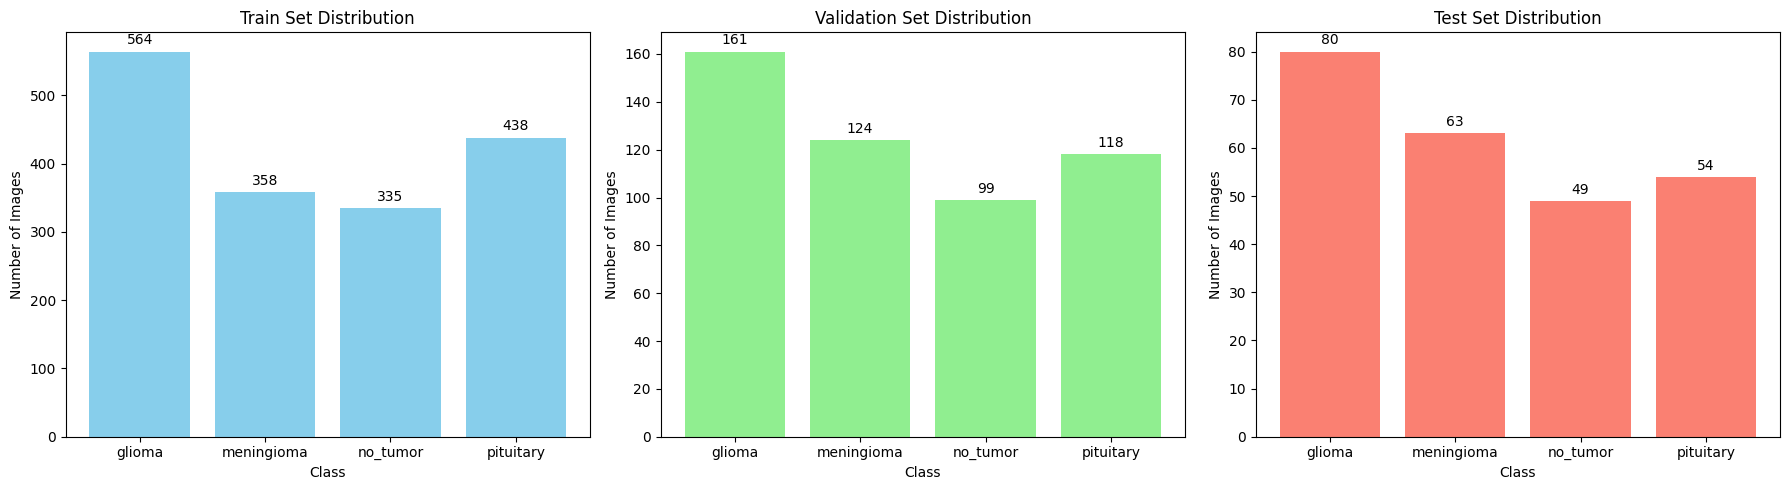

In [ ]:
import matplotlib.pyplot as plt

def plot_all_distributions(train_counts, val_counts, test_counts):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    datasets = [
        ("Train Set Distribution", train_counts, "skyblue"),
        ("Validation Set Distribution", val_counts, "lightgreen"),
        ("Test Set Distribution", test_counts, "salmon")
    ]

    for ax, (title, counts, color) in zip(axes, datasets):
        bars = ax.bar(counts.keys(), counts.values(), color=color)
        ax.set_title(title)
        ax.set_xlabel("Class")
        ax.set_ylabel("Number of Images")

        # Add numbers on top of bars
        ax.bar_label(bars, padding=3)

    plt.tight_layout()
    plt.show()

# Call function
plot_all_distributions(train_counts, val_counts, test_counts)


#Data Preprocessing

In [4]:
# -----------------------------
# 3️⃣ Performance optimization
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ==============================
# 2️⃣ Compute class weights
# ==============================
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Unbatch and collect labels safely
y_train = np.array([y.numpy() for x, y in train_ds.unbatch()])

# Compute classes and class weights
classes = np.unique(y_train)
class_weights = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train)))

print("Classes:", classes)
print("Class weights:", class_weights)

Classes: [0 1 2 3]
Class weights: {np.int32(0): np.float64(0.7513297872340425), np.int32(1): np.float64(1.183659217877095), np.int32(2): np.float64(1.2649253731343284), np.int32(3): np.float64(0.9674657534246576)}


## Custom CNN

In [5]:
# ==============================
# Data Augmentation
# ==============================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ==============================
# Build Custom CNN
# ==============================
model_cnn = models.Sequential([
    data_augmentation,                     # ✅ augmentation
    layers.Rescaling(1./255, input_shape=(224,224,3)),  # ✅ normalization

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

# ==============================
# Compile
# ==============================
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_cnn.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ==============================
# Callbacks
# ==============================
early_stop_cnn = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cnn = ModelCheckpoint(
    filepath="best_custom_cnn.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# ==============================
# Train
# ==============================
EPOCHS = 20
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop_cnn, checkpoint_cnn],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3520 - loss: 1.2934
Epoch 1: val_accuracy improved from -inf to 0.60159, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.3536 - loss: 1.2917 - val_accuracy: 0.6016 - val_loss: 0.9575
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5659 - loss: 1.0508
Epoch 2: val_accuracy improved from 0.60159 to 0.70518, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 54s 73ms/step - accuracy: 0.5664 - loss: 1.0500 - val_accuracy: 0.7052 - val_loss: 0.8026
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6222 - loss: 0.9659
Epoch 3: val_accuracy improved from 0.70518 to 0.74701, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6230 - loss: 0.9648 - val_accuracy: 0.7470 - val_loss: 0.6908
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6825 - loss: 0.8415
Epoch 4: val_accuracy did not improve from 0.74701
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6826 - loss: 0.8412 - val_accuracy: 0.7410 - val_loss: 0.6864
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7349 - loss: 0.7965
Epoch 5: val_accuracy improved from 0.74701 to 0.74900, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7347 - loss: 0.7961 - val_accuracy: 0.7490 - val_loss: 0.6739
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7429 - loss: 0.7133
Epoch 6: val_accuracy improved from 0.74900 to 0.79880, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7430 - loss: 0.7130 - val_accuracy: 0.7988 - val_loss: 0.5737
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7395 - loss: 0.6750
Epoch 7: val_accuracy did not improve from 0.79880
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7398 - loss: 0.6746 - val_accuracy: 0.7928 - val_loss: 0.5609
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7891 - loss: 0.6092
Epoch 8: val_accuracy did not improve from 0.79880
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7888 - loss: 0.6099 - val_accuracy: 0.7809 - val_loss: 0.5751
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7968 - loss: 0.6201
Epoch 9: val_accuracy did not improve from 0.79880
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7964 - loss: 0.6205 - val_accuracy: 0.6713 - val_loss: 0.7622
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7831 - loss: 0.6232
Epoch 10: val_accuracy did not improve fro

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7965 - loss: 0.5858 - val_accuracy: 0.8108 - val_loss: 0.5074
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8093 - loss: 0.5582
Epoch 12: val_accuracy improved from 0.81076 to 0.82072, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8093 - loss: 0.5582 - val_accuracy: 0.8207 - val_loss: 0.5581
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7946 - loss: 0.5674
Epoch 13: val_accuracy did not improve from 0.82072
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7949 - loss: 0.5671 - val_accuracy: 0.7968 - val_loss: 0.5805
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8269 - loss: 0.5022
Epoch 14: val_accuracy did not improve from 0.82072
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8268 - loss: 0.5024 - val_accuracy: 0.8207 - val_loss: 0.4963
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8047 - loss: 0.5777
Epoch 15: val_accuracy did not improve from 0.82072
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8050 - loss: 0.5767 - val_accuracy: 0.8147 - val_loss: 0.4798
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8241 - loss: 0.5059
Epoch 16: val_accuracy did not impro

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8395 - loss: 0.4705 - val_accuracy: 0.8347 - val_loss: 0.4735
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8301 - loss: 0.4763
Epoch 18: val_accuracy improved from 0.83466 to 0.84661, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8301 - loss: 0.4764 - val_accuracy: 0.8466 - val_loss: 0.4336
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8279 - loss: 0.4741
Epoch 19: val_accuracy did not improve from 0.84661
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8280 - loss: 0.4740 - val_accuracy: 0.7689 - val_loss: 0.6684
Epoch 20/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8366 - loss: 0.4787
Epoch 20: val_accuracy did not improve from 0.84661
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8365 - loss: 0.4786 - val_accuracy: 0.8207 - val_loss: 0.4937
Restoring model weights from the end of the best epoch: 18.


In [6]:
# ==============================
# 8️⃣ Evaluate on Test Set
# ==============================
test_loss, test_acc = model_cnn.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - accuracy: 0.7990 - loss: 0.5316
Test Accuracy: 0.8293, Test Loss: 0.4749


In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Convert unbatched test labels to 1D array
y_true = np.array([y.numpy() for x, y in test_ds.unbatch()])

# Get predictions from the model
y_pred = np.argmax(model_cnn.predict(test_ds), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
cr = classification_report(
    y_true,
    y_pred,
    target_names=['glioma', 'meningioma', 'no_tumor', 'pituitary']
)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Confusion Matrix:
 [[69  8  1  2]
 [ 2 39 16  6]
 [ 2  2 45  0]
 [ 1  0  2 51]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.86      0.90        80
  meningioma       0.80      0.62      0.70        63
    no_tumor       0.70      0.92      0.80        49
   pituitary       0.86      0.94      0.90        54

    accuracy                           0.83       246
   macro avg       0.82      0.84      0.82       246
weighted avg       0.84      0.83      0.83       246



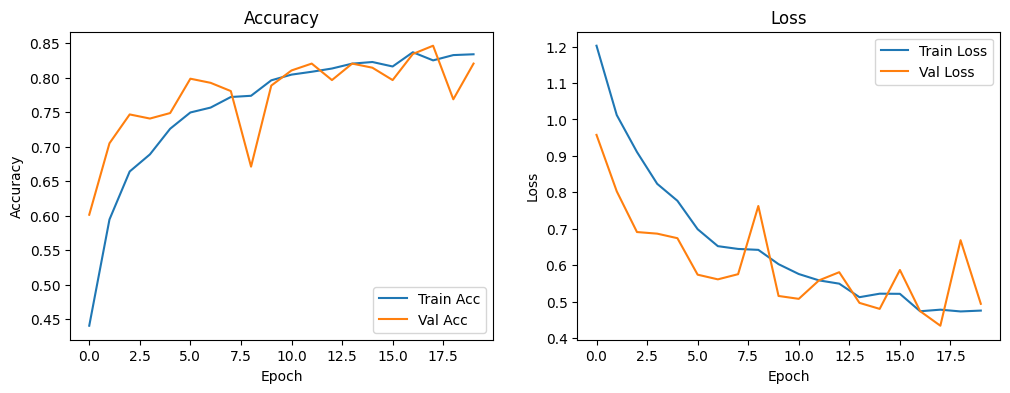

In [8]:
# 3. Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Transfer Learning

**Features of the below pipeline:**
- Data loading & caching → memory-efficient.
- Data augmentation → improves generalization.
- Transfer learning → **EfficientNetB0** & **InceptionV3** with custom top layers.
- Fine-tuning → top layers of base model after initial training.
- Evaluation → test accuracy.
- Grad-CAM → sanity check for model focus on tumors.

## Transfer learning models

In [ ]:
# -----------------------------
# Preprocess datasets externally
# -----------------------------
def preprocess_dataset(ds, model_name):
    preprocess_fn = preprocess_dict[model_name]
    return ds.map(lambda x, y: (preprocess_fn(tf.cast(x, tf.float32)), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

# -----------------------------
# Training loop (same as before)
# -----------------------------
models_to_train = ['ResNet50', 'InceptionV3', 'EfficientNetB0']
histories, results = {}, {}

for model_name in models_to_train:
    print(f"\n🔹 Training {model_name}...")

    # Preprocess datasets for this model
    train_ds_pre = preprocess_dataset(train_ds, model_name).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds_pre   = preprocess_dataset(val_ds, model_name).cache().prefetch(tf.data.AUTOTUNE)

    # Build model
    model = build_transfer_model(base_model_name=model_name)

    history = model.fit(
        train_ds_pre,
        validation_data=val_ds_pre,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=get_callbacks(model_name),
        verbose=1
    )

    # Save final model
    model.save(f"{model_name}_final.h5")
    histories[model_name] = history



🔹 Training ResNet50...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step - accuracy: 0.2590 - loss: 1.9486 - val_accuracy: 0.4562 - val_loss: 1.2214
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.4205 - loss: 1.3369 - val_accuracy: 0.5936 - val_loss: 0.9635
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.5361 - loss: 1.1344 - val_accuracy: 0.6653 - val_loss: 0.8100
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.6543 - loss: 0.8921 - val_accuracy: 0.7311 - val_loss: 0.7098
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.6703 - loss: 0.8740 - val_accuracy: 0.7729 - val_loss: 0.6309
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.7386 - loss: 0.6989 - val_accuracy: 0.7789 - val_loss: 0.5813
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7540 - loss: 0.6514 - val_accuracy: 0.8147 - val_loss: 0.5448
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7710 - l


🔹 Training InceptionV3...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 540ms/step - accuracy: 0.2859 - loss: 1.5664 - val_accuracy: 0.4741 - val_loss: 1.1700
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.4778 - loss: 1.2224 - val_accuracy: 0.6036 - val_loss: 0.9842
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - accuracy: 0.5772 - loss: 1.0648 - val_accuracy: 0.6813 - val_loss: 0.8560
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.6249 - loss: 0.9398 - val_accuracy: 0.7171 - val_loss: 0.7768
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.6819 - loss: 0.8265 - val_accuracy: 0.7450 - val_loss: 0.7184
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.6887 - loss: 0.8062 - val_accuracy: 0.7629 - val_loss: 0.6745
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.7244 - loss: 0.7193 - val_accuracy: 0.7669 - val_loss: 0.6422
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.742


🔹 Training EfficientNetB0...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 473ms/step - accuracy: 0.3053 - loss: 1.4719 - val_accuracy: 0.5359 - val_loss: 1.2127
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5011 - loss: 1.2379 - val_accuracy: 0.6295 - val_loss: 1.0817
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5911 - loss: 1.1050 - val_accuracy: 0.6813 - val_loss: 0.9836
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6546 - loss: 1.0085 - val_accuracy: 0.6892 - val_loss: 0.9062
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6823 - loss: 0.9256 - val_accuracy: 0.7092 - val_loss: 0.8443
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6983 - loss: 0.8605 - val_accuracy: 0.7331 - val_loss: 0.7932
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6872 - loss: 0.8705

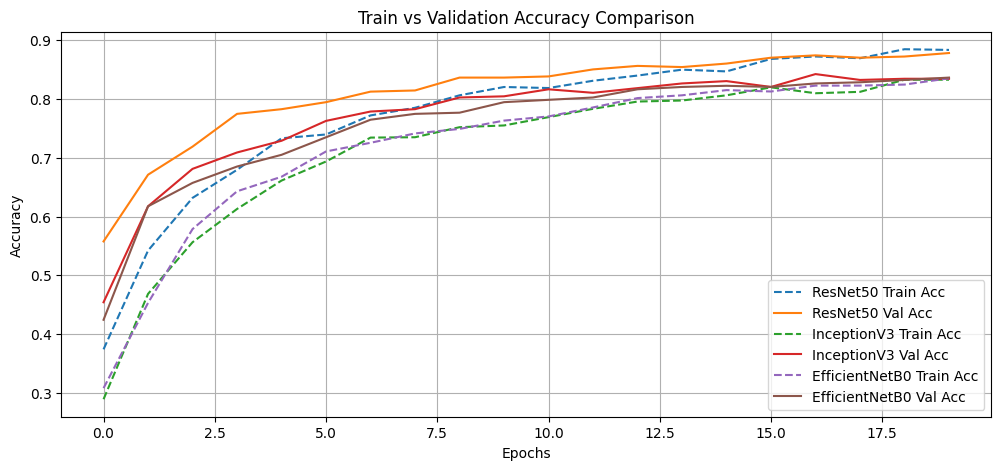

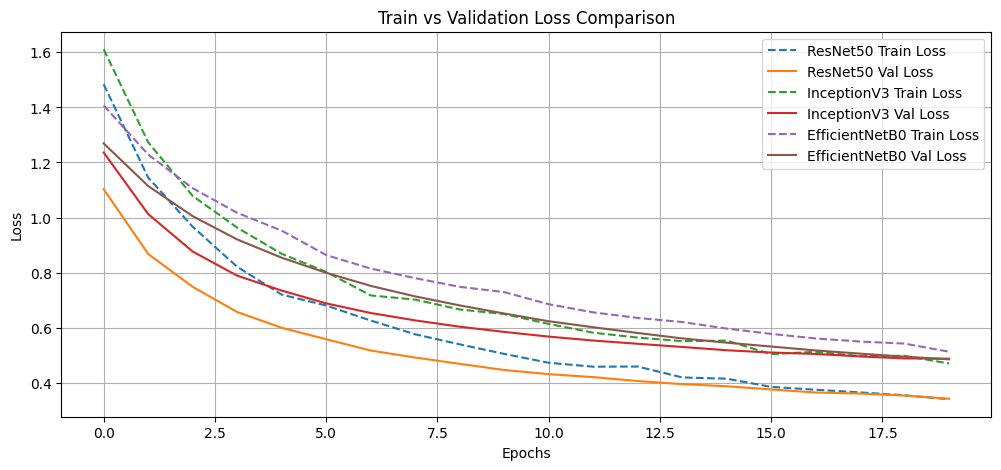

In [14]:
import matplotlib.pyplot as plt

# -----------------------------
# Accuracy Comparison
# -----------------------------
plt.figure(figsize=(12,5))
for name, hist in histories.items():
    plt.plot(hist.history['accuracy'], linestyle='--', label=f'{name} Train Acc')
    plt.plot(hist.history['val_accuracy'], linestyle='-', label=f'{name} Val Acc')

plt.title("Train vs Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Loss Comparison
# -----------------------------
plt.figure(figsize=(12,5))
for name, hist in histories.items():
    plt.plot(hist.history['loss'], linestyle='--', label=f'{name} Train Loss')
    plt.plot(hist.history['val_loss'], linestyle='-', label=f'{name} Val Loss')

plt.title("Train vs Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


##Model Evaluation


🔹 Evaluating ResNet50 on test set...
Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.85      0.88        80
  meningioma       0.74      0.76      0.75        63
    no_tumor       0.91      0.84      0.87        49
   pituitary       0.85      0.98      0.91        54

    accuracy                           0.85       246
   macro avg       0.86      0.86      0.85       246
weighted avg       0.86      0.85      0.85       246

Test Accuracy: 0.8537


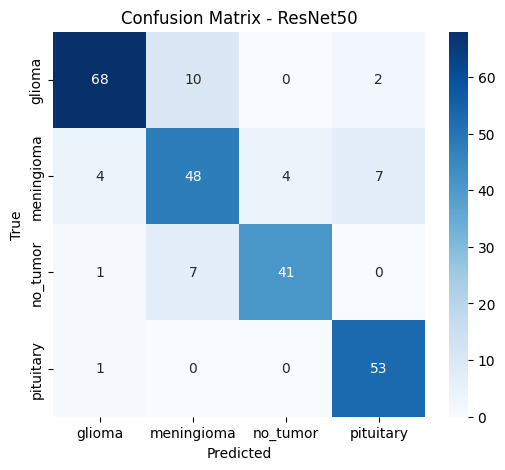


🔹 Evaluating InceptionV3 on test set...
Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.81      0.84        80
  meningioma       0.70      0.73      0.71        63
    no_tumor       0.85      0.84      0.85        49
   pituitary       0.88      0.93      0.90        54

    accuracy                           0.82       246
   macro avg       0.82      0.83      0.82       246
weighted avg       0.82      0.82      0.82       246

Test Accuracy: 0.8211


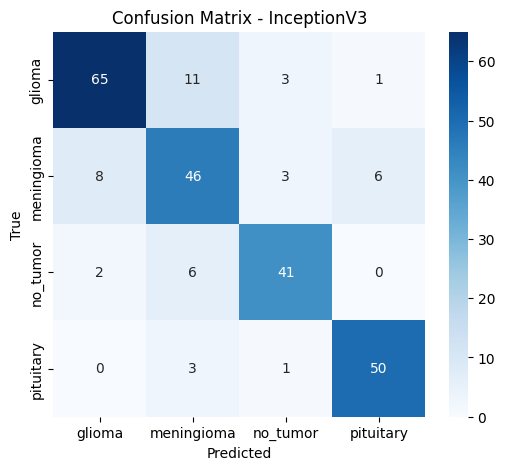


🔹 Evaluating EfficientNetB0 on test set...
Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.86      0.86        80
  meningioma       0.75      0.68      0.72        63
    no_tumor       0.89      0.84      0.86        49
   pituitary       0.82      0.94      0.88        54

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.83       246
weighted avg       0.83      0.83      0.83       246

Test Accuracy: 0.8293


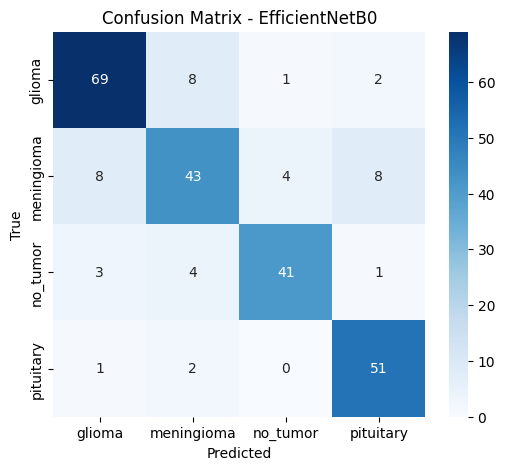


🔹 Test Accuracy Summary:
ResNet50: 0.8537
InceptionV3: 0.8211
EfficientNetB0: 0.8293


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf

# -----------------------------
# Function: Evaluate a single model
# -----------------------------
def evaluate_model(model, model_name, test_ds, class_names, plot_matrix=True):
    print(f"\n🔹 Evaluating {model_name} on test set...")

    # Preprocess test set according to model
    test_ds_pre = preprocess_dataset(test_ds, model_name).cache().prefetch(tf.data.AUTOTUNE)

    # True labels and predictions
    y_true, y_pred = [], []
    for x_batch, y_batch in test_ds_pre:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Plot confusion matrix
    if plot_matrix:
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return acc

# -----------------------------
# Load models (best checkpoints)
# -----------------------------
resnet_model = tf.keras.models.load_model("best_ResNet50.keras")
inception_model = tf.keras.models.load_model("best_InceptionV3.keras")
efficientnet_model = tf.keras.models.load_model("best_EfficientNetB0.keras")

# -----------------------------
# Evaluate all models
# -----------------------------
accuracies = {}
accuracies["ResNet50"] = evaluate_model(resnet_model, "ResNet50", test_ds, class_names)
accuracies["InceptionV3"] = evaluate_model(inception_model, "InceptionV3", test_ds, class_names)
accuracies["EfficientNetB0"] = evaluate_model(efficientnet_model, "EfficientNetB0", test_ds, class_names)

print("\n🔹 Test Accuracy Summary:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")


## Model Comparision


In [16]:
from sklearn.metrics import accuracy_score

print("\n🔹 Comparison of Train, Validation, and Test Accuracy:\n")

# Assuming you already have test accuracies stored from evaluate_model
# Example: test_accuracies = {"ResNet50": 0.6951, "InceptionV3": 0.2195, "EfficientNetB0": 0.8211}

for model_name in models_to_train:
    print(f"=== {model_name} ===")

    # 1️⃣ Train & Validation Accuracy from history
    train_acc = histories[model_name].history['accuracy'][-1]  # last epoch
    val_acc   = histories[model_name].history['val_accuracy'][-1]

    # 2️⃣ Test Accuracy from previous evaluation
    test_acc = accuracies.get(model_name, None)

    # 3️⃣ Print comparison
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Val Accuracy   : {val_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}\n")



🔹 Comparison of Train, Validation, and Test Accuracy:

=== ResNet50 ===
Train Accuracy : 0.8838
Val Accuracy   : 0.8785
Test Accuracy  : 0.8537

=== InceptionV3 ===
Train Accuracy : 0.8330
Val Accuracy   : 0.8347
Test Accuracy  : 0.8211

=== EfficientNetB0 ===
Train Accuracy : 0.8354
Val Accuracy   : 0.8367
Test Accuracy  : 0.8293




📊 Final Model Accuracy Comparison
ResNet50: 0.8537
InceptionV3: 0.8211
EfficientNetB0: 0.8293


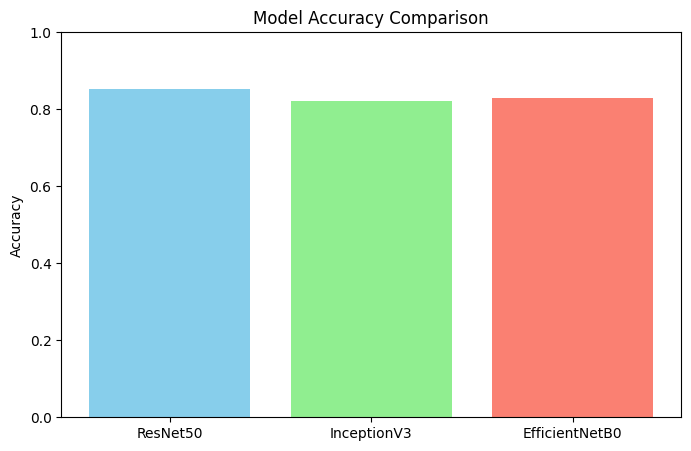

In [17]:
# -----------------------------
# Final Accuracy Comparison
# -----------------------------
print("\n📊 Final Model Accuracy Comparison")
for model_name, acc in accuracies.items():
    print(f"{model_name}: {acc:.4f}")

# Bar plot for accuracy
plt.figure(figsize=(8,5))
plt.bar(accuracies.keys(), accuracies.values(), color=["skyblue","lightgreen","salmon","orange"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

## Hyperparameter tuning for Resnet

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Parameters
# -----------------------------
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = len(classes)
DROPOUT_RATE = 0.3
EPOCHS = 20
BATCH_SIZE = 16

# -----------------------------
# Data Augmentation
# -----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------------
# Preprocess datasets
# -----------------------------
def preprocess_dataset(ds, model_name='ResNet50'):
    preprocess_fn = resnet50.preprocess_input
    return ds.map(lambda x, y: (preprocess_fn(tf.cast(x, tf.float32)), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_ds_pre = preprocess_dataset(train_ds).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds_pre   = preprocess_dataset(val_ds).cache().prefetch(tf.data.AUTOTUNE)
test_ds_pre  = preprocess_dataset(test_ds).cache().prefetch(tf.data.AUTOTUNE)

# -----------------------------
# Build fine-tuned ResNet50
# -----------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = True

# Unfreeze top 20% layers
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Custom head
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # small LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_ckpt = ModelCheckpoint("ResNet50_finetuned.h5", monitor='val_accuracy', save_best_only=True)

# -----------------------------
# Train model
# -----------------------------
history = model.fit(
    train_ds_pre,
    validation_data=val_ds_pre,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, model_ckpt],
    verbose=1
)




Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3748 - loss: 1.4246

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - accuracy: 0.3775 - loss: 1.4195 - val_accuracy: 0.7510 - val_loss: 0.7190
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7492 - loss: 0.7075

53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.7498 - loss: 0.7062 - val_accuracy: 0.8287 - val_loss: 0.4764
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8446 - loss: 0.4774

53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.8447 - loss: 0.4770 - val_accuracy: 0.8685 - val_loss: 0.3750
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8886 - loss: 0.3593

53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.8886 - loss: 0.3591 - val_accuracy: 0.8924 - val_loss: 0.3226
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9066 - loss: 0.3100

53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - accuracy: 0.9067 - loss: 0.3097 - val_accuracy: 0.9084 - val_loss: 0.2901
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9126 - loss: 0.2728

53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.9129 - loss: 0.2723 - val_accuracy: 0.9203 - val_loss: 0.2678
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.9167 - loss: 0.2310 - val_accuracy: 0.9183 - val_loss: 0.2529
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9460 - loss: 0.1856

53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.9460 - loss: 0.1854 - val_accuracy: 0.9243 - val_loss: 0.2283
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9617 - loss: 0.1342

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.9616 - loss: 0.1345 - val_accuracy: 0.9283 - val_loss: 0.2189
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9659 - loss: 0.1216

53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.9659 - loss: 0.1217 - val_accuracy: 0.9303 - val_loss: 0.2201
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.9659 - loss: 0.1160 - val_accuracy: 0.9283 - val_loss: 0.2220
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9765 - loss: 0.0944

53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.9765 - loss: 0.0943 - val_accuracy: 0.9323 - val_loss: 0.2119
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9804 - loss: 0.0756

53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.9803 - loss: 0.0757 - val_accuracy: 0.9402 - val_loss: 0.2129
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.9879 - loss: 0.0637 - val_accuracy: 0.9382 - val_loss: 0.2099
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9901 - loss: 0.0567 - val_accuracy: 0.9382 - val_loss: 0.2184
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9911 - loss: 0.0483 - val_accuracy: 0.9363 - val_loss: 0.2185
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.9958 - loss: 0.0390 - val_accuracy: 0.9382 - val_loss: 0.2140
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9925 - loss: 0.0385 - val_accuracy: 0.9363 - val_loss: 0.2207
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9940 - loss: 0.0340 - val_accuracy: 0.9402 - val_loss: 0.2256


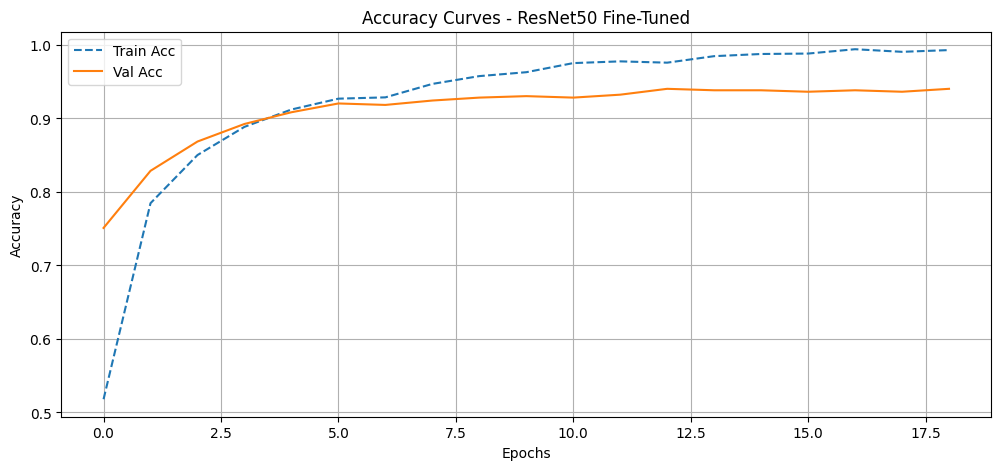

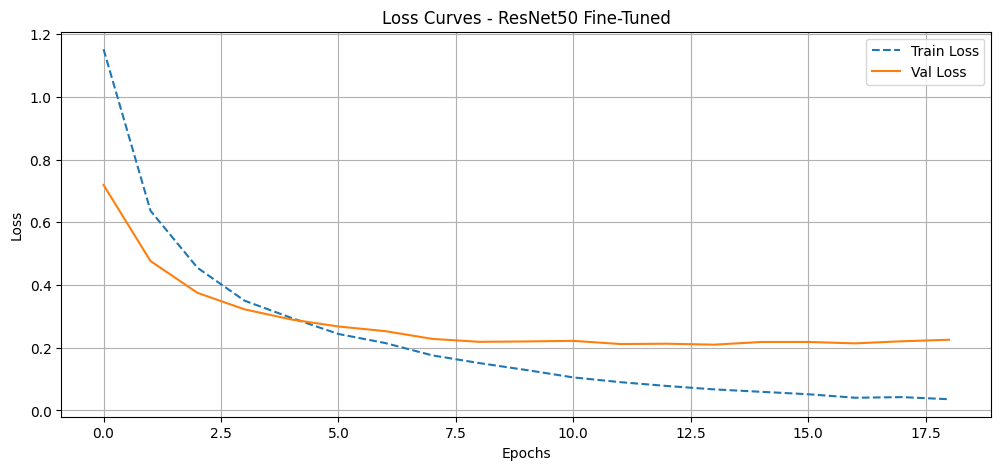

In [19]:
# -----------------------------
# Plot Accuracy & Loss Curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], linestyle='--', label='Train Acc')
plt.plot(history.history['val_accuracy'], linestyle='-', label='Val Acc')
plt.title("Accuracy Curves - ResNet50 Fine-Tuned")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], linestyle='--', label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='-', label='Val Loss')
plt.title("Loss Curves - ResNet50 Fine-Tuned")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        80
           1       0.87      0.94      0.90        63
           2       0.98      0.82      0.89        49
           3       0.93      1.00      0.96        54

    accuracy                           0.93       246
   macro avg       0.94      0.93      0.93       246
weighted avg       0.94      0.93      0.93       246



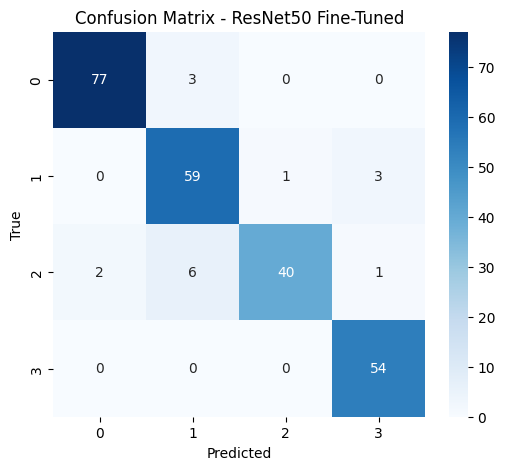

Test Accuracy: 0.9350


In [22]:
# Ensure class names are strings
class_names_str = [str(c) for c in classes]

# Then use it in classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names_str))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_str, yticklabels=class_names_str)
plt.title("Confusion Matrix - ResNet50 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Test accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")


In [23]:
# -----------------------------
# Train/Val/Test Accuracy Comparison
# -----------------------------
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]

print("\n🔹 Accuracy Comparison:")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Val Accuracy   : {val_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")




🔹 Accuracy Comparison:
Train Accuracy : 0.9929
Val Accuracy   : 0.9402
Test Accuracy  : 0.9350
